In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

True


In [14]:
DATA_PATH = "../../data/"
DEPTH_PATH = os.path.join(DATA_PATH, "data_depth_self_compiled")
TRAIN_PATH = os.path.join(DEPTH_PATH, "training")
TRAIN_RGB_PATH = os.path.join(TRAIN_PATH, "image_2")
TRAIN_DEPTH_PATH = os.path.join(TRAIN_PATH, "depth")

rgbs = sorted(os.listdir(TRAIN_RGB_PATH))
depths = sorted(os.listdir(TRAIN_DEPTH_PATH))

# x = cv2.imread(os.path.join(TRAIN_DEPTH_PATH, depths[3]))
# x = x[:,:,0]
# # print(np.unique(x))
# plt.figure(figsize=(20,10))
# plt.imshow(x)

# x1 = cv2.imread(os.path.join(TRAIN_RGB_PATH, rgbs[3]))
# plt.figure(figsize=(20,10))
# plt.imshow(x1)

# x = cv2.imread(os.path.join(TRAIN_DEPTH_PATH, depths[3]))
# x = x[:,:,0]
# x = x.reshape(1, 375, 1242)
# x = torch.tensor(x)
# t = transforms.Compose([transforms.Resize((240, 960))])
# x = t(x)
# print(x.shape, x.dtype)
# y = x.permute(1,2,0).to(torch.int8)
# print(y.shape, y.dtype)
# plt.figure(figsize=(20,10))
# plt.imshow(y)

data torch.Size([3, 120, 480]) torch.float32 torch.Size([1, 120, 480]) torch.float32


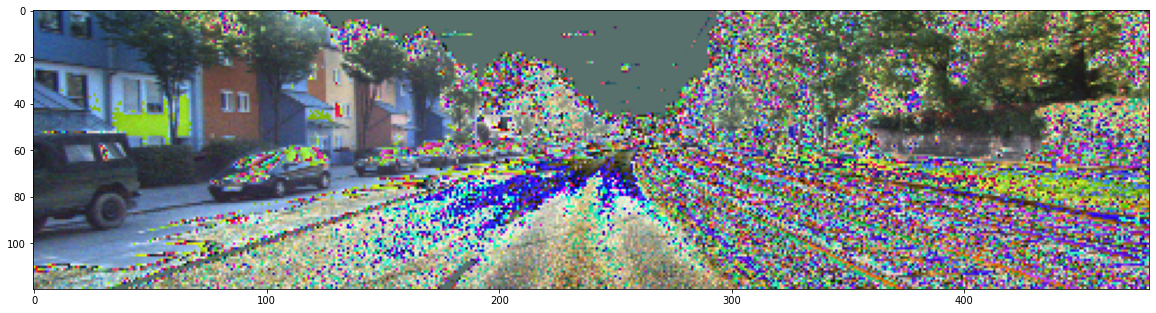

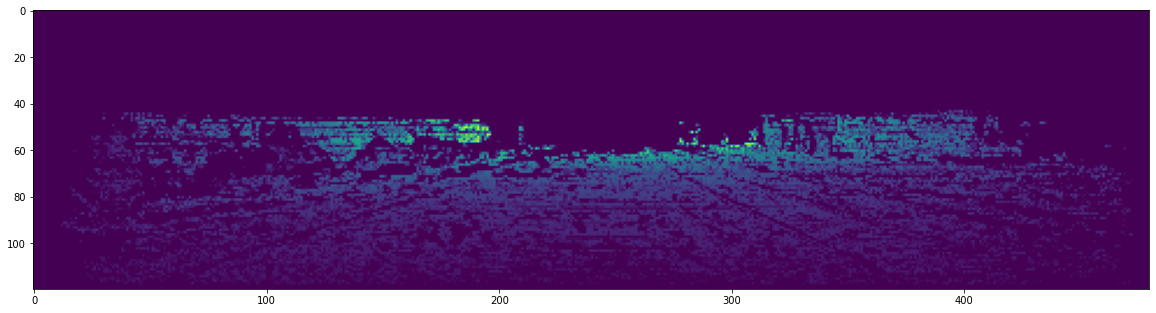

In [32]:
def read2Tensor(img_path, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    img_t = read_image(img_path).to(torch.float32).unsqueeze(0).to(device)
    transform = transforms.Compose([transforms.Resize( (120, 480) ),
                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    img_t = transform(img_t)  
    return img_t

def pred2Img(pred):
    pred = torch.argmax(pred, dim=1).squeeze(0)
    pred = pred.to("cpu").to(torch.uint8)
    return pred

class KITTI_DEP(Dataset):
    def __init__(self, rgb_path, label_path, transform=transforms.Compose([transforms.Resize( (120, 480) ),
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
                          target_transform=transforms.Compose([transforms.Resize( (120, 480) )]),
                          device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), qmark=True):
        self.rgb_path = rgb_path
        self.rgb_names = sorted(os.listdir(self.rgb_path))         
        
        self.label_path = label_path
        self.label_names = sorted(os.listdir(self.label_path))
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.device = device
        self.qmark = qmark

    def __len__(self):
        return len(self.rgb_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.rgb_path, self.rgb_names[idx])
        depth_path = os.path.join(self.label_path, self.label_names[idx])    
        
        img = read_image(img_path)
        img = img.to(torch.float32)
        if self.qmark:
            label = cv2.imread(depth_path)
            label = label[:,:,0]
            label = label.reshape(1, *label.shape)
            label = torch.tensor(label).to(torch.float32)
        else:
            label = read_image(depth_path).to(torch.float32)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
            
        return img.to(self.device), label.to(self.device)
    
    def example(self):
        image, label = self.__getitem__(6)
        print("data", image.shape, image.dtype, label.shape, label.dtype)        
        image = image.permute(1, 2, 0).to("cpu").to(torch.uint8)
        label = label.permute(1, 2, 0).to("cpu").to(torch.uint8)
        plt.figure(figsize=(20, 10))
        plt.imshow(image)
        plt.figure(figsize=(20, 10))
        plt.imshow(label)        
        
dataset = KITTI_DEP(TRAIN_RGB_PATH, TRAIN_DEPTH_PATH)
dataset.example()

# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
# for x, y in dataloader:
#     print(x.shape)
#     print(y.shape)

In [15]:
class HorizontalBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.bn = nn.BatchNorm2d(output_dim)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DownBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        return self.max_pool(x)
    
class UpBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.tconv = nn.ConvTranspose2d(input_dim, input_dim//2, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.tconv(x)
        return x
    
class ContractPath(nn.Module):
    def __init__(self, input_dim):
        super().__init__()        
        self.hb1 = HorizontalBlock(input_dim, 64)
        self.hb2 = HorizontalBlock(64, 128)
        self.hb3 = HorizontalBlock(128, 256)
        self.hb4 = HorizontalBlock(256, 512) 
        self.hb5 = HorizontalBlock(512,1024)         
        
        self.db = DownBlock()
        
    def forward(self, x):
        x1 = self.hb1(x)
        x1c = self.db(x1)
        
        x2 = self.hb2(x1c)
        x2c = self.db(x2)
        
        x3 = self.hb3(x2c)
        x3c = self.db(x3)
        
        x4 = self.hb4(x3c)
        x4c = self.db(x4) 
        
        x5 = self.hb5(x4c)
        return x5, x4, x3, x2, x1
    
class ExpandPath(nn.Module):
    def __init__(self, output_dim):
        super().__init__()        
        self.hb1 = HorizontalBlock(1024, 512)        
        self.hb2 = HorizontalBlock(512, 256)
        self.hb3 = HorizontalBlock(256, 128)
        self.hb4 = HorizontalBlock(128, 64)
        self.out_conv = nn.Conv2d(64, output_dim, kernel_size=1)
        
        self.ub1 = UpBlock(1024)
        self.ub2 = UpBlock(512)
        self.ub3 = UpBlock(256)
        self.ub4 = UpBlock(128)
        
    def forward(self, cp):
        x = cp[0]
        x = self.ub1(x) #512
        
        x_padded = torch.zeros(*cp[1].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[1]), 1) #1024
        x = self.hb1(x) #512
        x = self.ub2(x) #256
        
        x_padded = torch.zeros(*cp[2].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x        
        x = torch.cat((x_padded, cp[2]), 1) #512
        x = self.hb2(x) #256
        x = self.ub3(x) #128

        x_padded = torch.zeros(*cp[3].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[3]), 1) #256
        x = self.hb3(x) #128
        x = self.ub4(x) #64   

        x_padded = torch.zeros(*cp[4].shape, device=x.device)
        x_padded[:,:,:x.shape[2],:x.shape[3]] = x
        x = torch.cat((x_padded, cp[4]), 1) #128
        x = self.hb4(x) #64
        
        x = self.out_conv(x) #num class
        
        return x
                    
    
class UNet(nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()                
        self.cp = ContractPath(input_dim)
        self.ep = ExpandPath(num_class)

    def forward(self, x):
        feat_maps = self.cp(x)
        y = self.ep(feat_maps)
        return y
        
    
x = torch.randn(1, 3, 120, 480)
unet = UNet(3, 1)
y = unet(x)
print(y.shape)

torch.Size([1, 1, 120, 480])


In [18]:
loss_fn = nn.MSELoss()

y = torch.randn(1, 16, 120, 480)
x = torch.randn(1, 16, 120, 480)
print(x.shape, y.shape)
z = loss_fn(x, y)
z

torch.Size([1, 16, 120, 480]) torch.Size([1, 16, 120, 480])


tensor(2.0022)

In [27]:
def train(model, dataloader, num_epoch=400):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    loss_fn = nn.MSELoss()
    best_record = np.inf
    hist = []
    for epoch in range(num_epoch):
        running_loss = 0        
        tic = time.time()
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            print("batch", batch_idx, "/", len(dataloader), end='\r')
            pred = model(imgs)
            loss = loss_fn(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()           
            
            running_loss += loss.item() / len(dataloader)
            
        toc = time.time()
        print("epoch", epoch, "takes", toc-tic)
        hist.append(running_loss)
            
        if epoch % 1 == 0:
            print("epoch", epoch)
            print("running loss", running_loss)

        if best_record > running_loss:
            print("best record", best_record)
            best_record = running_loss
            best_model = deepcopy(model)
        
        if epoch % 50 == 47:
            model_path = "trained_model_dep"+str(epoch)+".pth"
            torch.save(best_model, model_path)
            files.download(model_path)
          
        plt.figure()
        plt.plot(hist)
        testViz(best_model)
            
    return best_model
        
def testViz(model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), num_example=5):
    test_img_names = sorted(os.listdir(TEST_RGB_PATH))
    for i, test_img_name in enumerate(test_img_names):
        img_path = os.path.join(TEST_RGB_PATH, test_img_name)
        img_t = read2Tensor(img_path)
        img = cv2.imread(img_path)

        tic = time.time()
        pred = model(img_t)
        pred = pred2Img(pred)
        toc = time.time()
        print("inference takes", toc-tic)

        plt.figure()
        plt.imshow(img) 
        plt.title(str(i)) 
        plt.figure()
        plt.imshow(pred)
        plt.title(str(i)) 

        if i+1 >= num_example:
            break

# TRAINED_MODELS_PATH = os.path.join(DATA_PATH, "trained_models")
# trained_model_path = os.path.join(TRAINED_MODELS_PATH, "trained_model99.pth")
# model = torch.load(trained_model_path)
# testViz(model)

In [33]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")        
device = torch.device("cpu")        

dataset = KITTI_DEP(TRAIN_RGB_PATH, TRAIN_DEPTH_PATH, device=device)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

unet = UNet(3, 1).to(device)
model = train(unet, dataloader)

KeyboardInterrupt: 

inference takes 0.019826650619506836
inference takes 0.019522428512573242
inference takes 0.019523143768310547
inference takes 0.01950669288635254
inference takes 0.01955437660217285
inference takes 0.0195462703704834
inference takes 0.019557714462280273
inference takes 0.01949286460876465
inference takes 0.019557952880859375
inference takes 0.019518375396728516
inference takes 0.0196683406829834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


inference takes 0.01962590217590332
inference takes 0.019559860229492188
inference takes 0.019566059112548828
inference takes 0.019567251205444336
inference takes 0.019504308700561523
inference takes 0.01952528953552246
inference takes 0.019544124603271484
inference takes 0.01961660385131836
inference takes 0.019537925720214844
inference takes 0.01958441734313965
inference takes 0.019681453704833984
inference takes 0.019559383392333984
inference takes 0.019562721252441406
inference takes 0.019582033157348633
inference takes 0.019562959671020508
inference takes 0.019561767578125
inference takes 0.0195310115814209
inference takes 0.019504785537719727
inference takes 0.01955270767211914


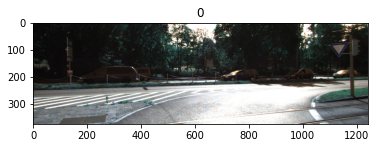

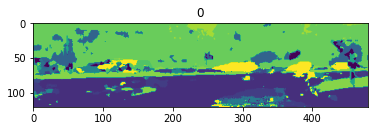

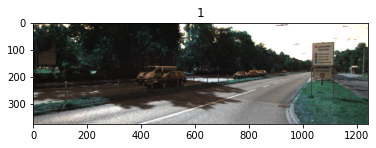

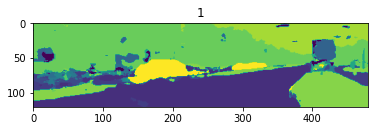

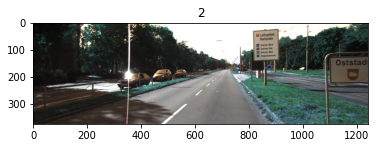

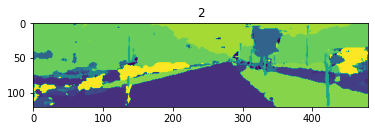

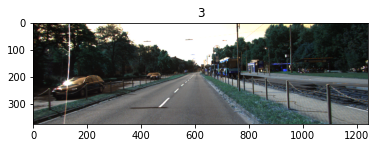

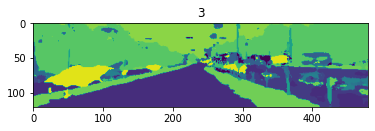

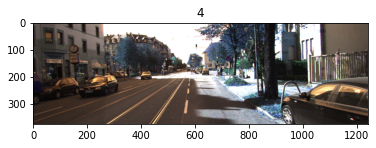

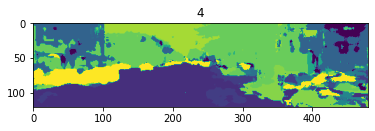

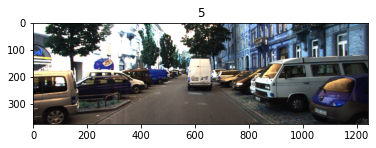

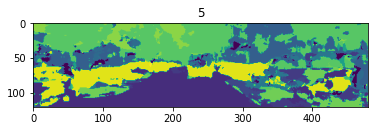

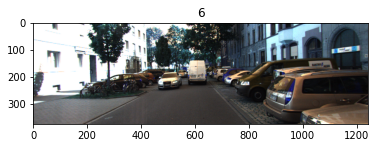

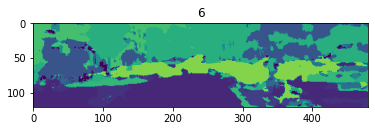

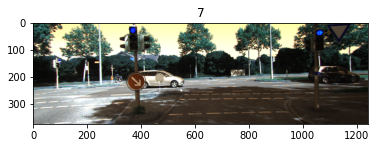

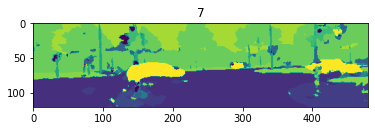

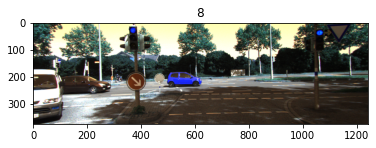

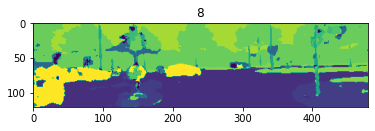

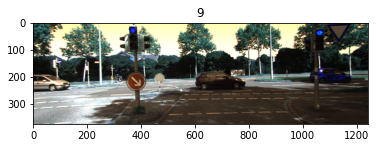

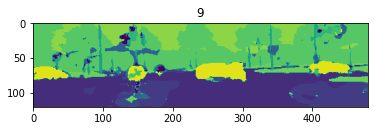

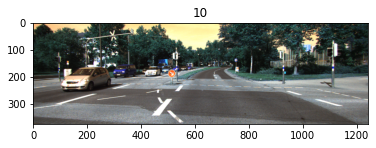

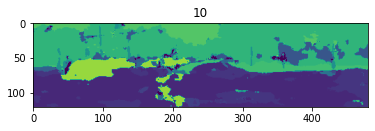

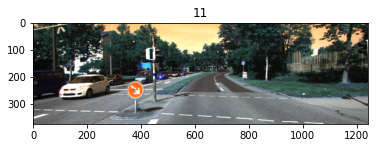

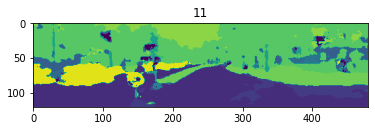

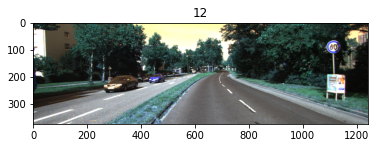

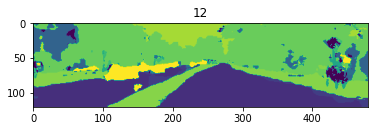

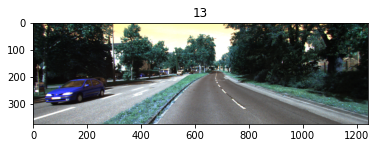

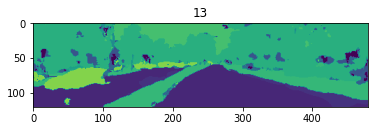

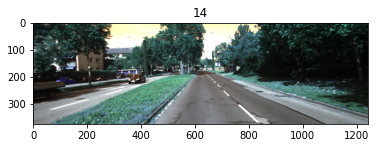

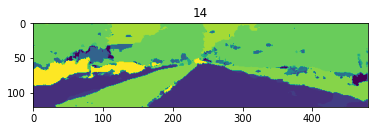

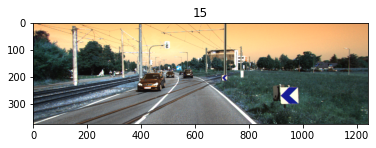

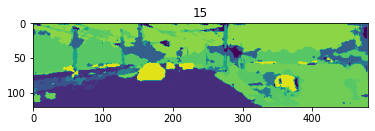

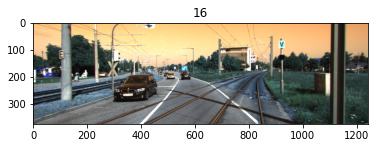

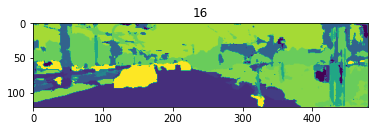

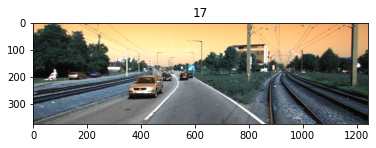

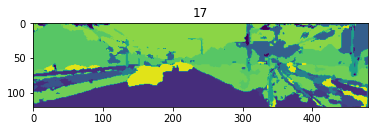

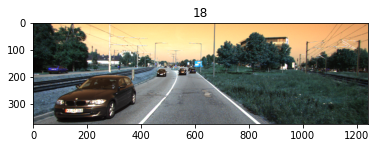

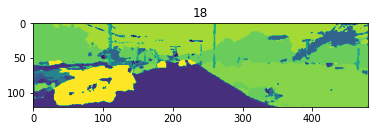

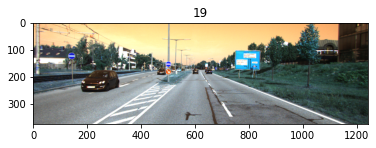

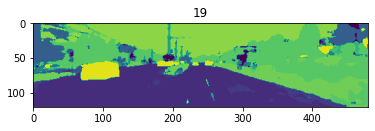

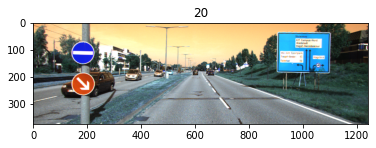

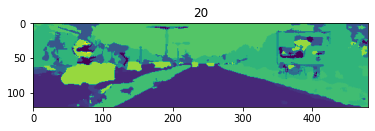

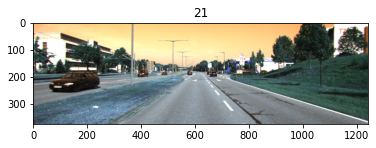

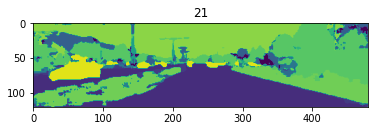

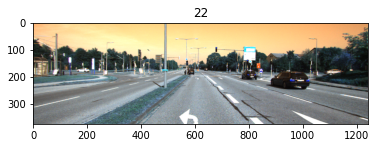

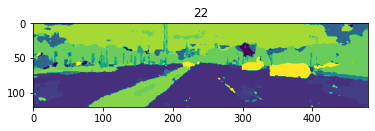

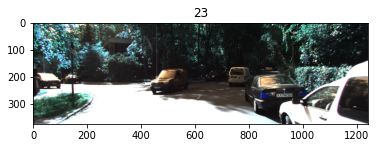

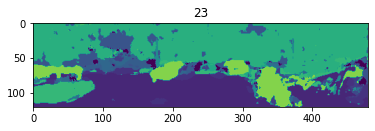

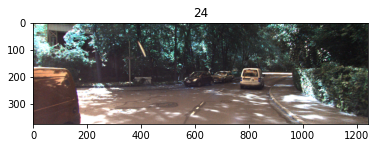

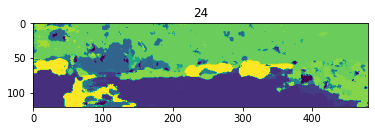

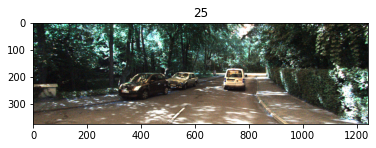

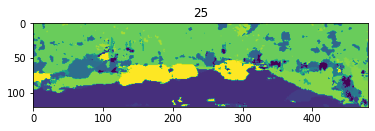

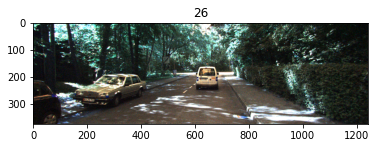

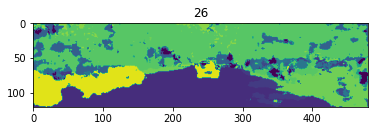

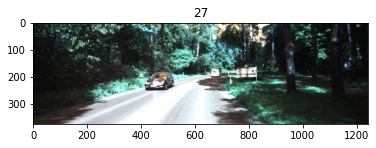

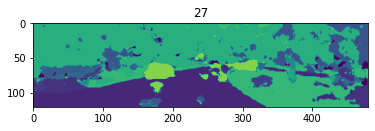

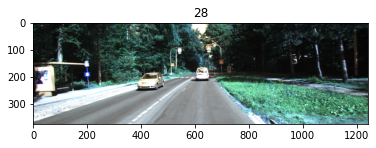

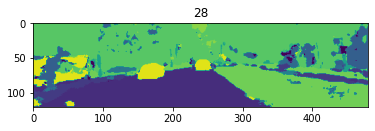

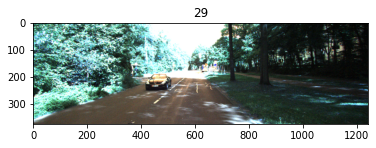

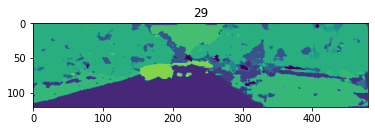

In [50]:
TRAINED_MODELS_PATH = os.path.join(DATA_PATH, "trained_models")
trained_model_path = os.path.join(TRAINED_MODELS_PATH, "trained_model348.pth")
model = torch.load(trained_model_path)
testViz(model, num_example=30)
